Implementing an Autoencoder in PyTorch

## Setup

We begin by importing our dependencies.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import time

Set our seed and other configurations for reproducibility.

In [20]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

We set the batch size, the number of training epochs, and the learning rate.

In [21]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [22]:
from model import *
from data import *

Wait for both datasets to be downloaded and verified.
Files already downloaded and verified
Files already downloaded and verified
Examples:


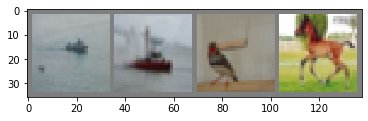

 ship       ship       bird      horse


In [23]:
dataset = Loader()
trainloader = dataset.trainloader
classes = dataset.classes


def examples(trainloader, classes):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print('      '.join('%5s' % classes[labels[j]] for j in range(4)))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


print('Examples:')
examples(trainloader, classes)

## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [26]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
net = AE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),weight_decay=1e-5)

print(torch.cuda.is_available())

True


We train our autoencoder for our specified number of epochs.

In [ ]:
start_time = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataset.trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
elapsed_time = time.time() - start_time
print(elapsed_time)

[1,  2000] loss: 0.158
[1,  4000] loss: 0.152
[1,  6000] loss: 0.149
[1,  8000] loss: 0.148
[1, 10000] loss: 0.146
[1, 12000] loss: 0.147
[2,  2000] loss: 0.148
[2,  4000] loss: 0.146
[2,  6000] loss: 0.148
[2,  8000] loss: 0.146
[2, 10000] loss: 0.145
[2, 12000] loss: 0.148
Finished Training

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(dataset.testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = AE()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in dataset.testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in dataset.testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Let's extract some test examples to reconstruct using our trained autoencoder.